In [35]:
import qutip
import numpy as np
import matplotlib.pyplot as plt

# Introduction
We shall be using qutrits to describe the three states involved in the controlled-z gates using a rydberg excited state $|r\rangle$ in addition to the hyperfine ground $|g\rangle$ and excited states $|e\rangle$ used for the digital basis. This corresponds to a "Vee" configuration for three-level systems:
<img src="files/three_states.png" alt="Three-state Configuration" style="width: 300px;"/>


# Basic Definitions

First we construct the basic states and operators:

In [188]:
# Three-state basis:
r = qutip.Qobj([[1],[0],[0]])
e = qutip.Qobj([[0],[1],[0]])
g = qutip.Qobj([[0],[0],[1]])

In [189]:
# Basic transition operators:
I = qutip.qeye(3)

rydX = qutip.Qobj([[0,0,1],[0,1,0],[1,0,0]])
rydY = qutip.Qobj([[0,0,-1j],[0,1,0],[1j,0,0]])
rydZ = qutip.Qobj([[1,0,0],[0,0,0],[0,0,-1]])

excX = qutip.Qobj([[1,0,0],[0,0,1],[0,1,0]])
excY = qutip.Qobj([[1,0,0],[0,0,-1j],[0,1j,0]])
excZ = qutip.Qobj([[0,0,0],[0,1,0],[0,0,-1]])

In [190]:
rydX

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]

Check these definitions work well

In [191]:
print(rydX * g) # Gives rydberg
print(excX * g) # Gives excited
print(rydX * r) # Gives ground
print(rydX * e) # Acts as identity (transition does not take place)
print(excX * r) # Acts as identity (transition does not take place)

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]]


# General Rotation
Let's construct a rotation operator on the qutrit, which represents the pulses acting in our three-level system. Each pulse is characterized by an amplitude $\Omega$ and frequency $\delta$ 

In [192]:
# Using Rotating Wave Approximation:
def ryd_rotate(omega_X, omega_Y,  delta):
    return 0.5*(omega_X*rydX + omega_Y*rydY + delta*rydZ)

def exc_rotate(omega_X, omega_Y, delta):
    return 0.5*(omega_X*excX + omega_Y*excY + delta*excZ)

# Rabi Oscillations
Let's first verify that the Rabi oscillation between both types of excited levels and the ground state work:

In [193]:
times = np.linspace(0,np.pi,60)

In [194]:
H = ryd_rotate(1,0,0) # Rotation along the X axis. Ground-Rydberg basis:
observables = [rydZ,excZ]
evolution = qutip.sesolve(H, g, times, observables)

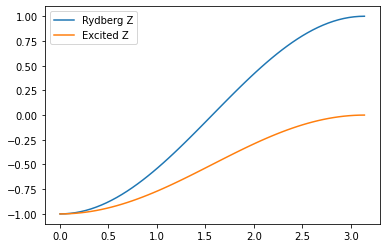

In [195]:
names=['Rydberg Z','Excited Z']
for i,results in enumerate(evolution.expect):
    plt.plot(times,results,label=f"{names[i]}")
    
plt.legend()

If we instead evolve with a digital-basis rotation:

In [196]:
H = exc_rotate(1,0,0) #Digital basis
evolution = qutip.sesolve(H, g, times, [rydZ,excZ])

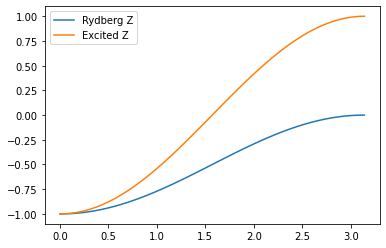

In [197]:
for i,results in enumerate(evolution.expect):
    plt.plot(times,results,label=f"{names[-i]}")
    
plt.legend()

# Two Atom System
Now we consider two atoms: one for control and one for the target of a Control-Z gate. They will also interact via a Van der Waals coupling, which will depend on the physical distance between the two qutrits

In [224]:
gg = qutip.tensor([g,g])

ge = qutip.tensor([g,e])
eg = qutip.tensor([e,g])
ee = qutip.tensor([e,e])

gr = qutip.tensor([g,r])
rg = qutip.tensor([r,g])
rr = qutip.tensor([r,r])

er = qutip.tensor([e,r])
re = qutip.tensor([r,e])

In [225]:
#Define Operators
rydN = qutip.Qobj([[1,0,0],[0,0,0],[0,0,0]])

VdW = qutip.tensor([rydN,rydN])
rotation = qutip.tensor([ryd_rotate(1,0,0),I]) #Rotation in the Ground-Rydberg basis
bias =  qutip.tensor([I,rydN]) + qutip.tensor([rydN,I])       

observables = [qutip.tensor([rydN,I]),qutip.tensor([I,rydN])]

# Rydberg Blockade

If one of the atoms is in the ground state while the other one is in the rydberg state, we observe a blockade effect

1371.7421124828536
3.8146972656249987
0.0877914951989026


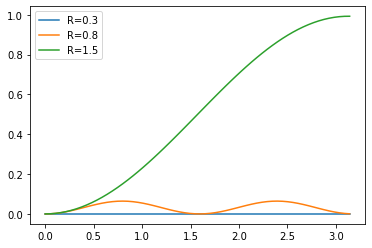

In [232]:

# Try different distances bewteen atoms:
for R in [0.3, 0.8, 1.5]:
    print(1/R**6)
    
    H = (1/R**6)*VdW + rotation - 0*bias
    evolution = qutip.sesolve(H, gr, times, observables) # Rotates the first atom around the x axis

    plt.plot(evolution.times, evolution.expect[0],label=f'R={R}')
    
plt.legend()

Notice how the population transfer is hindered when R is below the rydberg blockade radius. In fact in that region, the populated state will be the "bright" state $(|rg\rangle + |gr\rangle)/\sqrt{2}$. If we try the initial state $|gg\rangle$ or $|ge\rangle$, then the atoms succesfully populate the rydberg state.

1371.7421124828536
3.8146972656249987
0.0877914951989026


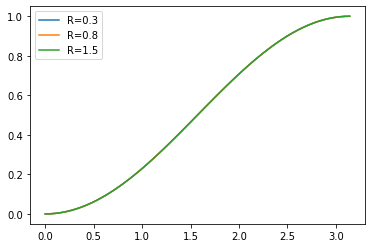

In [234]:
# Try different distances bewteen atoms:
for R in [0.3, 0.8, 1.5]:
    print(1/R**6)
    
    H = (1/R**6)*VdW + rotation - 0*bias
    evolution = qutip.sesolve(H, ge, times, observables) # Rotates the first atom around the x axis

    plt.plot(evolution.times, evolution.expect[0],label=f'R={R}')
    
plt.legend()

# Controlled-Z gate
Now we construct the series of pulses that implement the CZ gate as a sequence. We store the intermediate state after each step

In [235]:
def CZ(initial,distances=np.linspace(0.26,1.7,100),plots=False):
    """
    Implements the CZ gate pulse sequence. A range of distances between the atoms
    is automatically given but one can give specific values as parameters.
    Notice that the time steps are defined automatically
    """
    times = np.linspace(0,np.pi,40)
    
    control_rotation = qutip.tensor([ryd_rotate(1,0,0),I]) #Rotation in the Ground-Rydberg basis
    target_rotation = qutip.tensor([I,ryd_rotate(2,0,0)]) #Rotation in the Ground-Rydberg basis

    sequence = {
        "pi pulse control": control_rotation,
        "2pi pulse target": target_rotation, 
        "pi pulse control(again)": control_rotation
        }
    
    evolution_r =[]
    evolution_i =[]
    
    for R in distances:

        state = initial # set initial state
        for x in sequence:

            H = (1/R**6)*VdW + sequence[x] - 0*bias
            result = qutip.sesolve(H, state, times) # Without observables, we get the output state
            state = result.states[-1]

        scalar_prod = np.vdot(initial.data.toarray(),state.data.toarray())
        evolution_r.append(np.real(scalar_prod))
        #evolution_i.append(np.imag(scalar_prod))

    if plots:
        plt.plot(distances,evolution_r,label=f"Re <initial|psi_out>")
        #plt.plot(distances,evolution_i,label=f"Im <initial|psi_out>")
        plt.legend()
    
    return scalar_prod

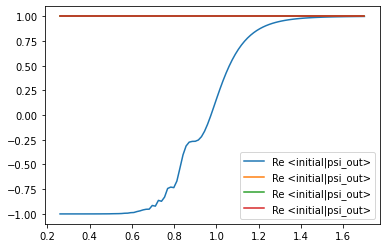

In [237]:
for initial in [gg,ge,eg,ee]:
    CZ(initial,plots=True)

Notice that the rydberg blockade acts only on the $|gg\rangle$ case, which corresponds to a "$|11\rangle$" state. If we place the atoms at $r<0.6$ we then get the following effective $CZ$ gate: 

In [244]:
for initial in [gg,ge,eg,ee]:
    print(CZ(initial,distances=[0.3]))

(-0.999997333027251-0.0022904781986179544j)
(0.9999999996632042+2.0243098355537435e-05j)
(0.9999999991628149+4.006099706850324e-05j)
(0.9999999981817073+6.030410934115191e-05j)
